In [1]:
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score, balanced_accuracy_score
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# Check for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
class Args:
    data_dir = '/kaggle/input/visual-exam-dataset-2/visual_dataset'  # Update this path if needed
    batch_size = 64
    epochs = 50
    lr = 0.001
    num_workers = 4  # Set to 0 if you encounter multiprocessing errors on Windows/macOS in notebooks
    dry_run = False  # Set to True to test the pipeline with just one batch

args = Args()

# Verify the folder contents one last time to be sure
if os.path.exists(args.data_dir):
    print(f"Dataset root: {args.data_dir}")
    print(f"Folders found: {os.listdir(args.data_dir)}")
else:
    print("Error: Path not found!")

Dataset root: /kaggle/input/visual-exam-dataset-2/visual_dataset
Folders found: ['test_degradato', 'sports_labels.csv', 'valid', 'test', 'train']


In [3]:
# Data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.4, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Define datasets using the specific folders 'train' and 'valid' found in your output
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(args.data_dir, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(args.data_dir, 'valid'), data_transforms['val'])
}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=args.batch_size,
                             shuffle=True, num_workers=args.num_workers, pin_memory=True)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Training samples: {dataset_sizes['train']}")
print(f"Validation samples: {dataset_sizes['val']}")

Number of classes: 100
Training samples: 19100
Validation samples: 500


In [4]:
import time
import copy
import numpy as np
import torch
from sklearn.metrics import f1_score

def train_model(
    model,
    dataloaders,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    device,
    args,
    patience=3,
    min_delta=0.0,
    monitor="val_loss",
    save_path="best_model.pth",
):
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = -1

    if monitor not in ("val_loss", "val_f1"):
        raise ValueError("monitor must be 'val_loss' or 'val_f1'")

    # Initialize "best" depending on monitor direction
    if monitor == "val_loss":
        best_metric = float("inf")
        mode = "min"
    else:
        best_metric = -float("inf")
        mode = "max"

    epochs_no_improve = 0

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc":  [], "val_acc":  [],
        "train_f1":   [], "val_f1":   [],
    }

    # Removed dry_run check; simply use args.epochs
    num_epochs = args.epochs

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        epoch_stats = {}

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            seen = 0

            all_preds = []
            all_targets = []

            for inputs, labels in dataloaders[phase]:
                # Removed the 'if dry_run break' check here

                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                bs = inputs.size(0)
                running_loss += loss.item() * bs
                running_corrects += torch.sum(preds == labels).item()
                seen += bs

                all_preds.append(preds.detach().cpu().numpy())
                all_targets.append(labels.detach().cpu().numpy())

            # Step LR scheduler once per epoch (after train phase)
            if phase == "train" and scheduler is not None:
                scheduler.step()

            # Calculate metrics
            denom = max(1, seen)
            epoch_loss = running_loss / denom
            epoch_acc = running_corrects / denom

            all_preds = np.concatenate(all_preds) if len(all_preds) else np.array([], dtype=np.int64)
            all_targets = np.concatenate(all_targets) if len(all_targets) else np.array([], dtype=np.int64)

            # Macro F1 for multi-class single-label
            if all_targets.size > 0:
                epoch_f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)
            else:
                epoch_f1 = 0.0

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1(macro): {epoch_f1:.4f}")

            epoch_stats[f"{phase}_loss"] = epoch_loss
            epoch_stats[f"{phase}_acc"] = epoch_acc
            epoch_stats[f"{phase}_f1"] = epoch_f1

        # Save history
        history["train_loss"].append(epoch_stats["train_loss"])
        history["val_loss"].append(epoch_stats["val_loss"])
        history["train_acc"].append(epoch_stats["train_acc"])
        history["val_acc"].append(epoch_stats["val_acc"])
        history["train_f1"].append(epoch_stats["train_f1"])
        history["val_f1"].append(epoch_stats["val_f1"])

        # Early stopping check (after val)
        current = epoch_stats[monitor]

        improved = False
        if mode == "min":
            improved = (best_metric - current) > min_delta
        else:
            improved = (current - best_metric) > min_delta

        if improved:
            best_metric = current
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} (best {monitor} at epoch {best_epoch}: {best_metric:.6f})")
            break

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed/60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best {monitor}: {best_metric:.6f} at epoch {best_epoch}")

    model.load_state_dict(best_model_wts)
    return model, history

In [5]:
# Initialize model
model = models.resnet18(weights=None) # Random initialization
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=args.lr)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Run Training
model, history = train_model(model, dataloaders, dataset_sizes, criterion, optimizer_ft, exp_lr_scheduler, device, args)

Epoch 0/49
----------
train Loss: 3.7217 Acc: 0.1181 F1(macro): 0.1093
val Loss: 3.1312 Acc: 0.1960 F1(macro): 0.1497
Epoch 1/49
----------
train Loss: 2.9997 Acc: 0.2399 F1(macro): 0.2266
val Loss: 2.4891 Acc: 0.3400 F1(macro): 0.2905
Epoch 2/49
----------
train Loss: 2.5354 Acc: 0.3382 F1(macro): 0.3258
val Loss: 2.2438 Acc: 0.4080 F1(macro): 0.3696
Epoch 3/49
----------
train Loss: 2.1747 Acc: 0.4180 F1(macro): 0.4090
val Loss: 1.8798 Acc: 0.5000 F1(macro): 0.4693
Epoch 4/49
----------
train Loss: 1.9043 Acc: 0.4804 F1(macro): 0.4741
val Loss: 1.8527 Acc: 0.5060 F1(macro): 0.4829
Epoch 5/49
----------
train Loss: 1.6249 Acc: 0.5457 F1(macro): 0.5411
val Loss: 1.5054 Acc: 0.5820 F1(macro): 0.5586
Epoch 6/49
----------
train Loss: 1.4392 Acc: 0.5985 F1(macro): 0.5953
val Loss: 1.3268 Acc: 0.6280 F1(macro): 0.6118
Epoch 7/49
----------
train Loss: 1.0276 Acc: 0.7187 F1(macro): 0.7164
val Loss: 0.9321 Acc: 0.7280 F1(macro): 0.7130
Epoch 8/49
----------
train Loss: 0.9176 Acc: 0.7505 F1(

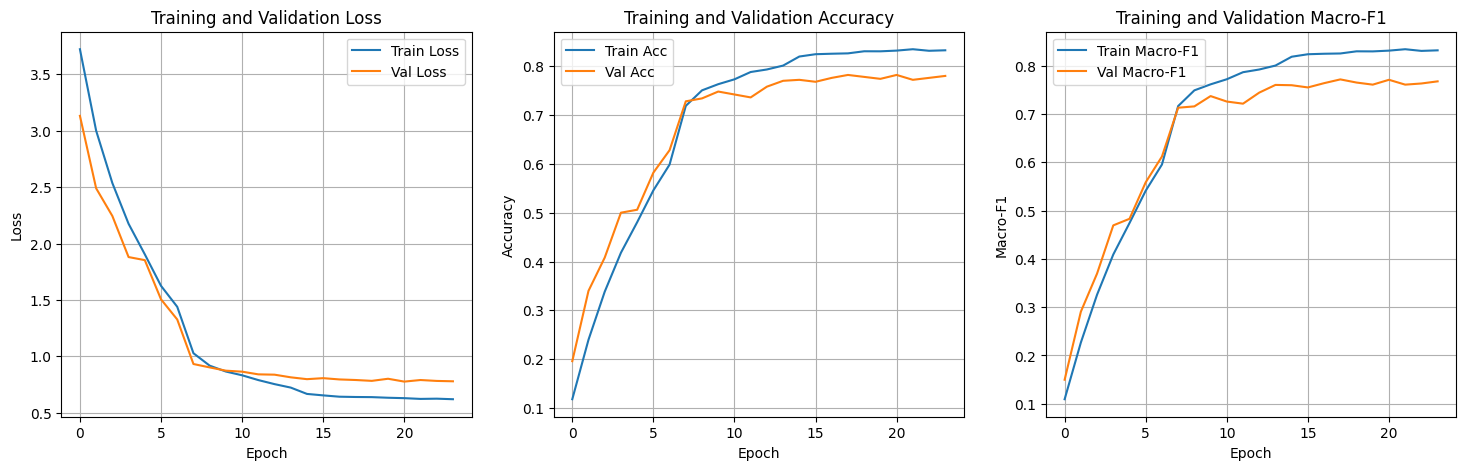

In [6]:
epochs_range = range(len(history["train_loss"]))
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history["train_loss"], label='Train Loss')
plt.plot(epochs_range, history["val_loss"], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history["train_acc"], label='Train Acc')
plt.plot(epochs_range, history["val_acc"], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)

# Macro-F1 (replaces mAP)
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history["train_f1"], label='Train Macro-F1')
plt.plot(epochs_range, history["val_f1"], label='Val Macro-F1')
plt.title('Training and Validation Macro-F1')
plt.xlabel('Epoch'); plt.ylabel('Macro-F1')
plt.legend(); plt.grid(True)

plt.show()

In [7]:
import torch
import os
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score

def evaluate_test_set(model, test_dir, batch_size=64, device='cuda'):
    """
    Evaluates the model on the test set and prints Accuracy and Macro-F1.
    """
    
    # 1. Check path
    if not os.path.exists(test_dir):
        print(f"Error: Test directory not found at {test_dir}")
        return

    # 2. Define Test Transforms (Standardize: Resize + CenterCrop)
    # We use the same normalization statistics as training
    test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # 3. Load Test Dataset
    # ImageFolder expects structure: root/class_x/xxx.png
    test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
    
    # Num_workers=4 is good for Linux/Kaggle. Set to 0 if on Windows/Mac to avoid fork errors.
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    print(f"Test samples found: {len(test_dataset)}")
    print(f"Classes found: {len(test_dataset.classes)}")

    # 4. Run Inference
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []

    print("Running evaluation on Test set...")
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # 5. Calculate Metrics
    test_acc = accuracy_score(all_targets, all_preds)
    test_f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    print("-" * 30)
    print(f"Test Set Accuracy:   {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"Test Set Macro F1:   {test_f1:.4f}")
    print("-" * 30)

    return test_acc, test_f1

# --- USAGE ---
# Define path
test_dir_path = '/kaggle/input/visual-exam-dataset/visual_dataset/test'

# Run evaluation
# 'model' should be your trained model (which was updated to the best weights at the end of training)
evaluate_test_set(model, test_dir_path, batch_size=args.batch_size, device=device)

Test samples found: 500
Classes found: 100
Running evaluation on Test set...
------------------------------
Test Set Accuracy:   0.8220 (82.20%)
Test Set Macro F1:   0.8179
------------------------------


(0.822, 0.8179378954378953)